In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [2]:
train_df = pd.read_csv('../input/fake-news/train.csv')
test_df = pd.read_csv('../input/fake-news/test.csv')

train_df.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [3]:
train_df.shape

(20800, 5)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


In [6]:
X = train_df.drop('label', axis=1)
y = train_df.label

assert X.shape[0] == y.shape[0]

In [7]:
import tensorflow as tf

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [8]:
vocab_size = 7000
sentence_size = 20
stemmer = PorterStemmer()
stopwords_en = stopwords.words('english')

In [9]:
def pre_process_textdata(text):
    
    text = str(text)
    re_out = re.sub(r'[^a-zA-Z]', ' ', text.strip())
    lower_out = re_out.lower()
    stop_words_out = [stemmer.stem(word) for word in lower_out.split() if word not in stopwords_en]
    final_review = ' '.join(stop_words_out)
    
    return final_review

In [10]:
X['title'] = X['title'].apply(lambda x: pre_process_textdata(x))
X.head(3)

,id,title,author,text
0,0,hous dem aid even see comey letter jason chaff...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,flynn hillari clinton big woman campu breitbart,Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,truth might get fire,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."


In [11]:
corpus = X.title
corpus[0:3]

0    hous dem aid even see comey letter jason chaff...
1      flynn hillari clinton big woman campu breitbart
2                                 truth might get fire
Name: title, dtype: object

In [12]:
onehot_encoded_data = []
for sentence in corpus:
    onehot_encoded_data.append(tf.keras.preprocessing.text.one_hot(sentence, vocab_size))
    
onehot_encoded_data[0:3]

[[5466, 5178, 6632, 1636, 3211, 2688, 2997, 2472, 3500, 5407],
 [745, 3186, 3113, 931, 3165, 3517, 714],
 [1543, 6941, 140, 5873]]

In [13]:
padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(onehot_encoded_data, maxlen=sentence_size, padding='pre')
padded_sentences[0:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 5466,
        5178, 6632, 1636, 3211, 2688, 2997, 2472, 3500, 5407],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  745, 3186, 3113,  931, 3165, 3517,  714],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1543, 6941,  140, 5873]],
      dtype=int32)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50, input_length=sentence_size),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            350000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 441,777
Trainable params: 441,777
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

history = model.fit(padded_sentences, y, epochs=50, validation_split=0.3, callbacks=[early_stopping], batch_size=32)

Epoch 1/50
400/400 [==============================] - 16s 34ms/step - loss: 0.3963 - accuracy: 0.7981 - val_loss: 0.1952 - val_accuracy: 0.9180
Epoch 2/50
400/400 [==============================] - 13s 33ms/step - loss: 0.1330 - accuracy: 0.9498 - val_loss: 0.1918 - val_accuracy: 0.9229
Epoch 3/50
400/400 [==============================] - 13s 32ms/step - loss: 0.0922 - accuracy: 0.9669 - val_loss: 0.2020 - val_accuracy: 0.9194
Epoch 4/50
400/400 [==============================] - 13s 32ms/step - loss: 0.0676 - accuracy: 0.9780 - val_loss: 0.2273 - val_accuracy: 0.9120
Epoch 5/50
400/400 [==============================] - 13s 32ms/step - loss: 0.0483 - accuracy: 0.9842 - val_loss: 0.2615 - val_accuracy: 0.9176
Epoch 6/50
400/400 [==============================] - 13s 33ms/step - loss: 0.0351 - accuracy: 0.9878 - val_loss: 0.2972 - val_accuracy: 0.9191
Epoch 7/50
400/400 [==============================] - 13s 33ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.3223 - val_accuracy:

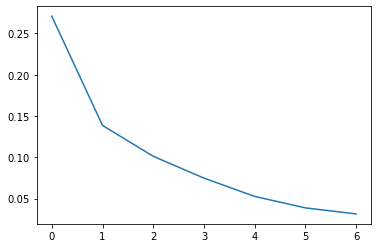

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [17]:
test_df['title'] = test_df['title'].apply(lambda x: pre_process_textdata(x))
onehot_encoded_data_test = []
for sentence in test_df.title:
    onehot_encoded_data_test.append(tf.keras.preprocessing.text.one_hot(sentence, vocab_size))
    
padded_sentences_test = tf.keras.preprocessing.sequence.pad_sequences(onehot_encoded_data_test, maxlen=sentence_size, padding='pre')    

In [18]:
result = model.predict_classes(padded_sentences_test)
print(result.shape)

output = pd.DataFrame( data={"id":test_df["id"], "label":result.reshape(-1, )} )
output.to_csv( "submission.csv", index=False, quoting=3 )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(5200, 1)
